### Import Libraries

In [49]:
! pip install keras-tqdm

In [50]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array, ImageDataGenerator)

# nice progress bars for learning
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

# Modelling helpers
from sklearn.metrics import confusion_matrix, classification_report

# Helper libraries
import numpy as np
import pandas as pd
import time
import random
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.5.0


In [51]:
#Overall Program Execution Time
program_start_time = time.time()

In [52]:
# verify GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [53]:
# set consistent random seed
random_seed = 62
np.random.seed(random_seed)  
tf.random.set_seed(random_seed)

Load fashion_mnist data using keras dataset, it bundles same data set as described in https://github.com/zalandoresearch/fashion-mnist

In [54]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(raw_train_data, raw_train_labels), (raw_test_data, raw_test_labels) = fashion_mnist.load_data()

print("Load Summary")
print("-"*12)
print("Training data shape: ", np.shape(raw_train_data))
print("Training labels Shape: ", np.shape(raw_train_labels))
print("Testing data shape: ", np.shape(raw_test_data))
print("Testing labels Shape: ", np.shape(raw_test_labels))
print("Unique class labels: ", np.unique(raw_train_labels))

Load Summary
------------
Training data shape:  (60000, 28, 28)
Training labels Shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Testing labels Shape:  (10000,)
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


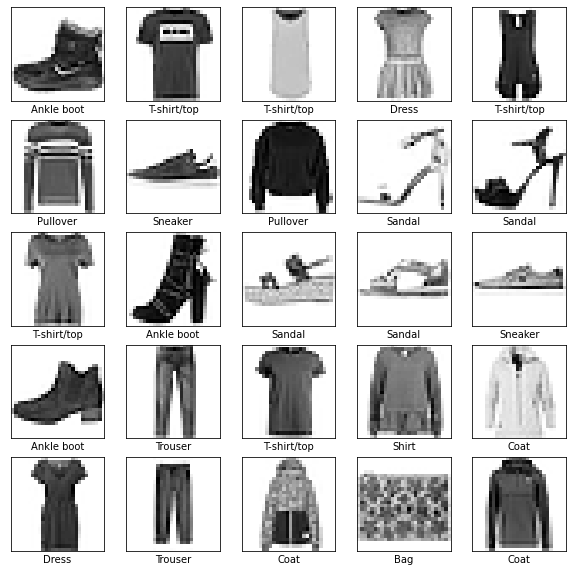

In [55]:
# Each image is mapped to a single label. 
# Since the class names are not included with the dataset, mapping them to use for image plots
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Review loaded data
# Verifiying some sample images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(raw_train_data[i], cmap='Greys')
    plt.xlabel(class_names[raw_train_labels[i]])
plt.show()

#### **Summary** <br/>
It is a training dataset comprised of 60,000 small square 28×28 pixel images of items of 10 types of clothing; while test dataset is comprised of 10,000 rows. The train:test split is 85:15.

### Data Visualization and augmentation

Class distribution


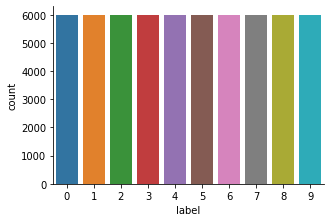

In [56]:
df = pd.DataFrame(raw_train_labels, columns=['label'])
print("Class distribution")
sns.catplot(x='label', data=df, kind='count', height=3, aspect= 1.5)


In [57]:
# For easier plotting of the images in the dataset, we define a plotting function that we will use quite often to visualize intermediate results.
def plot_images(imgs, labels=None, rows=1, figsize=(20,8), fontsize=14):
    figure = plt.figure(figsize=figsize)
    cols = max(1,len(imgs) // rows-1)
    labels_present = False
    # checking if labels is a numpy array
    if type(labels).__module__ == np.__name__:
        labels_present=labels.any()
    elif labels:
        labels_present=True
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols+1, i+1)
        # axis off, but leave a bounding box
        plt.tick_params(
            axis='both',
            which='both',
            bottom='off',
            top='off',
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
        # plot labels if present
        if labels_present:
            subplot.set_title(labels[i], fontsize=fontsize)
        figure.tight_layout()    
        plt.imshow(imgs[i][:,:,0], cmap='Greys')
        
    plt.show()

# Extract n random samples of each class from the dataset
def get_random_sample(number_of_samples=2):
    x = []
    y = []
    labels = []
    for category_number in range(0,10):
        # get all samples of a category
        train_data_category = X_train[y_train==category_number]
        # pick a number of random samples from the category
        train_data_category = train_data_category[np.random.randint(train_data_category.shape[0], 
                                                                    size=number_of_samples), :]
        x.extend(train_data_category)
        y.append([category_number]*number_of_samples)
        for i in range(number_of_samples):
          labels.append(class_names[category_number])
        #labels.append(class_names[category_number])
        
    return np.asarray(x).reshape(-1, 28, 28, 1), y, labels 

### Bring the train and test data in the required format. <br>Print the shapes of train and test data.

In [58]:
# Prepare Pixel Data
# each image in the dataset are unsigned integers in the range between black and white, or 0 and 255
# normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1] i.e. dividing the pixel values by the maximum value (255)
X_train = np.asarray(raw_train_data / 255.0 , dtype=float).reshape(-1, 28, 28, 1)
X_test = np.asarray(raw_test_data / 255.0 , dtype=float).reshape(-1, 28, 28, 1)

y_train = np.asarray(raw_train_labels , dtype=np.int32)
y_test= np.asarray(raw_test_labels , dtype=np.int32)

# # data -> reshape the images to have single color channel
# X_train = train_data.reshape(-1, 28, 28, 1)
# X_test = test_data.reshape(-1, 28, 28, 1)

# labels -> one-hot encoding 
# there are 10 classes and that classes are represented as unique integers
# transforming the integer into a 10 element binary vector with a 1 for the index of the class value
y_train_data = to_categorical(raw_train_labels)
y_test_data = to_categorical(raw_test_labels)

print("Post Data Preparation, Data Summary")
print("-"*35)
print("Training data shape: ", np.shape(X_train))
print("Training labels Shape: ", np.shape(y_train))
print("Testing data shape: ", np.shape(X_test))
print("Testing labels Shape: ", np.shape(y_test))
print("Sample class labels: ", y_train[0], y_test[0])
print("Sample (one-hot encoded) class labels: ", y_train_data[0], y_test_data[0])
print("Unique class labels: ", np.unique(y_train))

Post Data Preparation, Data Summary
-----------------------------------
Training data shape:  (60000, 28, 28, 1)
Training labels Shape:  (60000,)
Testing data shape:  (10000, 28, 28, 1)
Testing labels Shape:  (10000,)
Sample class labels:  9 9
Sample (one-hot encoded) class labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


#### Plot at least two samples from each class of the dataset

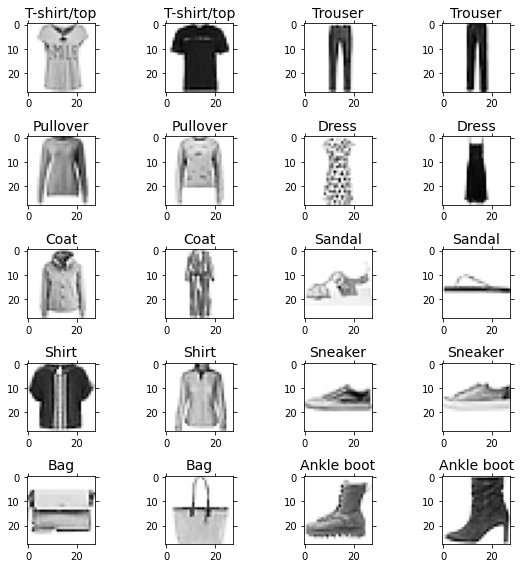

In [59]:
# The same samples will be used later for augmentation purpose as well
x_samples, y_samples, labels = get_random_sample(number_of_samples=2)
 
#y_samples = to_categorical(y_samples)
    
#print(np.shape(x_samples))
#print(np.shape(y_samples))
#print(np.shape(labels))
plot_images(x_samples[0:20], labels, rows=5, figsize=(8,8))

#### Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

Original


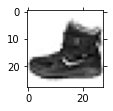

Shifted


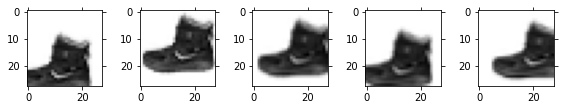

Rotation


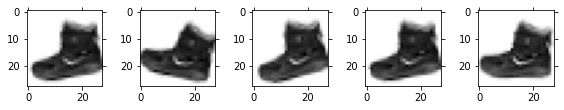

Zoom


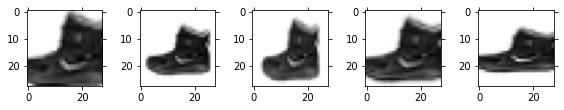

In [60]:
# Print original image
print("Original")
img = X_train[0]
plot_images([img], None, rows=1, figsize=(3,3))

# Shift -> random_shift allows to randomly shift by a given fraction of the imagesize in each direction.
print("Shifted")
img_shifted = [ random_shift(
    img, 
    wrg=0.2, 
    hrg=0.2, 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_shifted, None, rows=1, figsize=(8,8))

# Rotation -> With the random_rotation transformer we can rotate the image randomly by up to x degrees clockwise or counterclockwise. Here we specify a maximum rotation of 20 degrees.
print("Rotation")
img_rotated = [ random_rotation(
    img, 
    20, 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
        fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_rotated, None, rows=1, figsize=(8,8))

# Zoom -> random_zoom zooms in and out of an image. We can specify a minimum (here 0.7) and a maximum value (here 1.3) for the zoom. 
# A value bigger than 1.0 zooms in, thus making the object in the image bigger. A value smaller than 1.0 zooms out.
print("Zoom")
img_zoomed = [ random_zoom(
    img,
    zoom_range=(0.7,1.3),
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_zoomed, None, rows=1, figsize=(8,8))

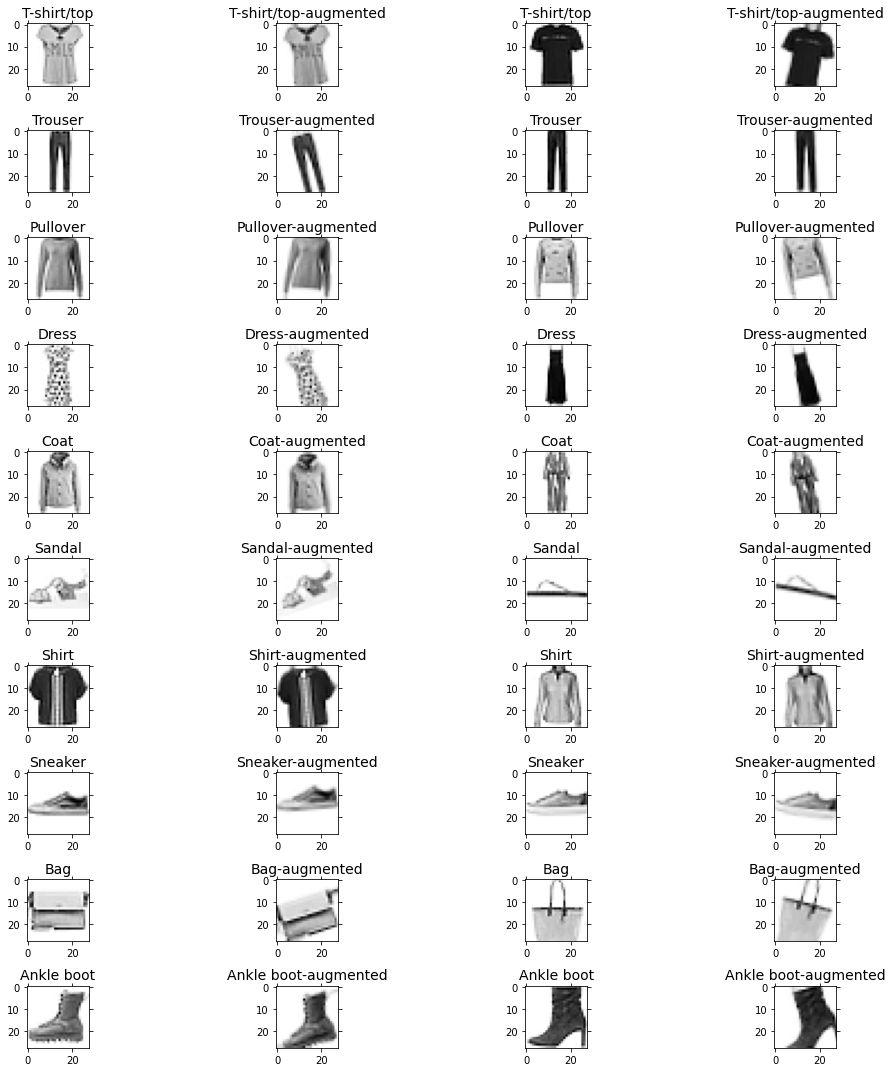

In [61]:
# As required for assignment, 
# Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. 
# Print the augmented image and the original image for each class and each augmentation.

# Using ImageDataGenerator to perform this operation. Using ImageDataGenerator we combine required transformation in one operation
# When we start the ImageDataGenerator it runs in an endless loop. We need to break out when we have collected required samples
datagen = ImageDataGenerator(
        rotation_range=20,
        height_shift_range=0.1
)

# Using same samples images which we had plotting in previous step, 
# x_samples, y_samples, labels
# print(np.shape(x_samples))
# print(np.shape(y_samples))
# print(np.shape(labels))

transform_img = []
transform_labels = []
idx = 0
for img in x_samples:
  transform_img.append(img)
  transform_labels.append(labels[idx])

  batches = 0
  max_batches = 1
  img_gen = []
  for x_batch in datagen.flow(img.reshape((1,) + img.shape), batch_size=max_batches):
      img_gen.append(x_batch[0])
      batches += 1
      if batches >= max_batches:
          # generator loops indefinetly
          break

  transform_img.append(img_gen[0])
  transform_labels.append(labels[idx]+"-augmented")
  idx += 1
  
# print(np.shape(transform_img))
# print(np.shape(transform_labels))
plot_images(transform_img, transform_labels, rows=10, figsize=(15,15))

### Model Building <br/>
- Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.
- Add L2 regularization to all the layers.
- Add one layer of dropout at the appropriate position and give reasons.
- Choose the appropriate activation function for all the layers.
- Print the model summary.


In [62]:
def plot_hist_loss_acc(results):
  #results.history
  accuracy = results.history['accuracy']
  loss = results.history['loss']
  val_accuracy = results.history['val_accuracy']
  val_loss = results.history['val_loss']

  epochs = range(1,len(accuracy)+1)

  plt.plot(epochs, accuracy, 'bo', label='Training Acc')
  plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title("Training and validation Loss")
  plt.legend()
  plt.figure()


def plot_hist_loss_acc_v2(results):
  #results.history
  pd.DataFrame(results.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1) # set vertical range to [0-1]
  plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_172 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_173 (Dense)            (None, 100)               30100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 10)                1010      
Total params: 356,910
Trainable params: 356,910
Non-trainable params: 0
_______________________________________________

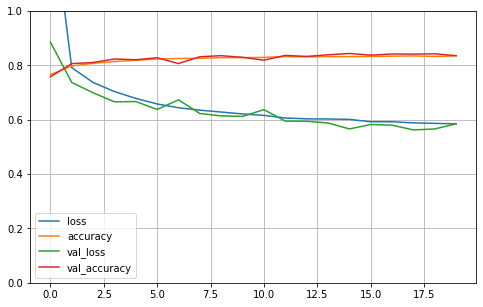

In [63]:
# Build the model
model = keras.Sequential()

# Input Layer
# The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). 
# Basically this layer as unstacks rows of pixels in the image and line them up. This layer has no parameters to learn; it only reformats the data.
model.add(keras.layers.Flatten(input_shape=(28, 28)))

# Adding 3 Hidden tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. We use different neurons with activation function = 'relu'

# adding L2 Regularization
model.add(keras.layers.Dense(300, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(300, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Typically, dropout is applied after the non-linear activation function (a) 
# However, when using rectified linear units (ReLUs), it might make sense to apply dropout before the non-linear activation (b) for reasons of computational efficiency depending on the particular code implementation.
# (a): Fully connected, linear activation -> ReLU -> Dropout -> …
# (b): Fully connected, linear activation -> Dropout -> ReLU -> …
# Infact we verified all the 3 scenarios , interesting all gave nearly similar test loss and accuracy score, but because before output gave lowest testing loss, we finalised the same
#            1) After Input (loss: 0.3621 - accuracy: 0.8675) 
#            2) Inbetween Hidden Layer (0.3715 - accuracy: 0.8639) 
#            3) Before Output Layer (loss: 0.3456 - accuracy: 0.8827)
# adding dropout 50%, just after ReLU layer, and before non-linear activation function (before output layer)
model.add(keras.layers.Dropout(0.1))

# Output Layer
# Given that the problem is a multi-class classification, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. 
# The last layer is a dense layer with a softmax activation function that classifies the 10 categories of the data and has 10 neurons.
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

# Model Compile
# Loss function — calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. 
#                 we chose the sparse_categorical_crossentropy loss function. Cross-entropy is the default loss function to use for a multi-class classification problem, 
#                 and it's sparse because our targets are not one-hot encodings but are integers.

# Learning Rate parameter has been selected as 0.001 based on evaluation done later for various lr=[1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Evaluation
start_time = time.time()

results = model.fit(X_train, y_train,epochs= 20, validation_split = 0.2)

model.save('my_keras_model.h5')

print()
print("Training time took %s seconds ---" % "{:.2f}".format(time.time() - start_time))
print()

# Model Evaluation
print("Training Accuracy: ", np.mean(results.history["val_accuracy"]))

# Model Evaluation using test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.86      0.79      1000
     Trouser       0.98      0.94      0.96      1000
    Pullover       0.73      0.73      0.73      1000
       Dress       0.85      0.83      0.84      1000
        Coat       0.73      0.74      0.73      1000
      Sandal       0.95      0.87      0.91      1000
       Shirt       0.56      0.53      0.55      1000
     Sneaker       0.90      0.90      0.90      1000
         Bag       0.96      0.91      0.94      1000
  Ankle boot       0.88      0.95      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



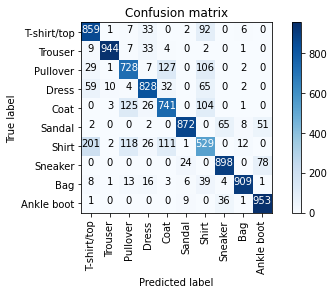

In [64]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)

# Computing Classification Report
print('Classification Report:')
print(classification_report(y_test, Y_pred_classes, target_names=class_names))

#### **Summary / Findings**<br>
*Confusion Matrix*
- Worst Class : Large number of Shirts are misclassified as Coat / T-shirt/Top / Pullover, followed by Coat misclassified as Pullover
- Best Class : Includes Trouser, Sandal, Bag

*Classification Report*
- Worst Class :  Precision for Pullover, Coat and Shirt is less than or approx 80%, which means that for these the model predicted almost less than 80% correctly as per the given label
- Best Class :  Precision for Trouser, Sandal, Bag, Ankle Boot, Sneaker (in 90% range)
- Both these results are very similar to our assesment from confusion matrix as well. 

### Print the two most incorrectly classified images for each class in the test dataset.

Top 2 Mismatch Image Indexes for each class
Class :  4 -> (10, 1) (17, 1)
Class :  7 -> (12, 1) (43, 1)
Class :  2 -> (20, 1) (46, 1)
Class :  5 -> (21, 1) (480, 1)
Class :  9 -> (23, 1) (68, 1)
Class :  3 -> (29, 1) (42, 1)
Class :  6 -> (40, 1) (117, 1)
Class :  1 -> (190, 1) (409, 1)
Class :  8 -> (209, 1) (299, 1)
Class :  0 -> (332, 1) (359, 1)


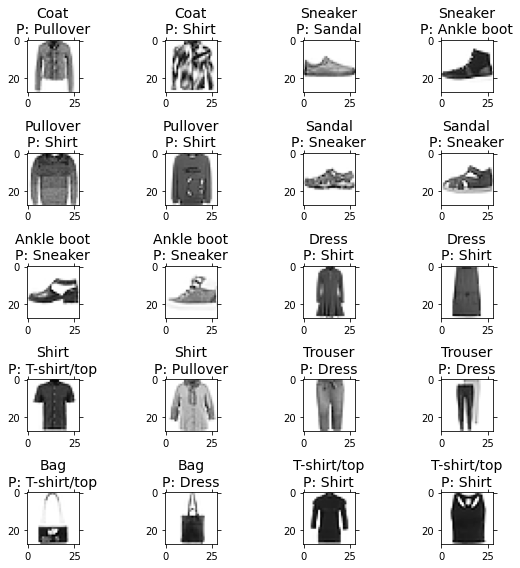

In [65]:
# Print the two most incorrectly classified images for each class in the test dataset
mismatch = dict()
for a in range(len(Y_pred)):
  if y_test[a] != np.argmax(Y_pred[a]):
    if y_test[a] in mismatch:
        mismatch[y_test[a]].append(a)
    else:
        mismatch[y_test[a]] = [a]

img = []
img_label = []

print("Top 2 Mismatch Image Indexes for each class")
for key, value in mismatch.items():
  #print(key, '->', value)
  #print("max->",max(value,key=value.count))
  d = defaultdict(int)
  for i in value:
      d[i] += 1
  #print(dict(d))
  result1 = max(d.items(), key=lambda x: x[1])

  # Get 2nd Top Item
  d = defaultdict(int)
  for i in value:
      if(i != result1[0]):
        d[i] += 1
  #print(dict(d))
  result2 = max(d.items(), key=lambda x: x[1])

  print("Class : ", key, "->",result1, result2)

  img_label.append(class_names[key]+"\nP: "+class_names[Y_pred_classes[result1[0]]])
  img.append(X_test[result1[0]])
  #img_label.append(class_names[key])
  img_label.append(class_names[key]+"\nP: "+class_names[Y_pred_classes[result2[0]]])
  img.append(X_test[result2[0]])

#Plotting all Images
plot_images(img, img_label, rows=5, figsize=(8,8))

Key -> Count of Total Mismatches
4 -> 259
7 -> 102
2 -> 272
5 -> 128
9 -> 47
3 -> 172
6 -> 471
1 -> 56
8 -> 91
0 -> 141
Top 2 Class (count) 6 ( 471 ) 4 ( 259 )


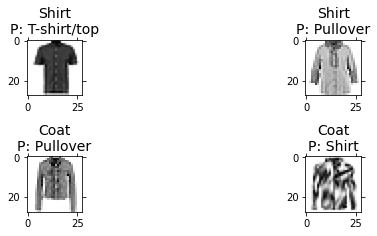

In [66]:
# Printing two images from Top 2 Mismatched Classes 
top1 = 0
top1_idx = 0
top2 = 0
top2_idx = 0
_init = False

print("Key -> Count of Total Mismatches")
for key, value in mismatch.items():
  count = len(value)
  print(key, '->', count)
  if(_init):
    if(count > top1):
      top1 = count
      top1_idx = key

    if(count > top2 and top1 != count):
      top2 = count
      top2_idx = key
  else:
    top1 = count
    top1_idx = key
    top2 = count
    top2_idx = key

    _init = True

print("Top 2 Class (count)", top1_idx, "(", top1, ")" , top2_idx, "(",top2,")")

# Get 2 Images from "Top 2 misclassified class"
img = []
img_label = []

values = mismatch.get(top1_idx)
img.append(X_test[values[0]])
#img_label.append(class_names[top1_idx])
img_label.append(class_names[top1_idx]+"\nP: "+class_names[Y_pred_classes[values[0]]])
img.append(X_test[values[1]])
#img_label.append(class_names[top1_idx])
img_label.append(class_names[top1_idx]+"\nP: "+class_names[Y_pred_classes[values[1]]])

values = mismatch.get(top2_idx)
img.append(X_test[values[0]])
#img_label.append(class_names[top2_idx])
img_label.append(class_names[top2_idx]+"\nP: "+class_names[Y_pred_classes[values[0]]])
img.append(X_test[values[1]])
#img_label.append(class_names[top2_idx])
img_label.append(class_names[top2_idx]+"\nP: "+class_names[Y_pred_classes[values[1]]])

plot_images(img, img_label, rows=5, figsize=(8,8))

### Evaluating How Dense our Network should be? Impact of adding Hidden Layer.<br>
We compare loss and accuracy for different hidden layers, keeping all other parameters and configuration for network same.


313/313 [==============================] - 1s 2ms/step - loss: 0.3413 - accuracy: 0.8819
Model - 3 Hidden layers - test loss: 34.12606418132782
Model - 3 Hidden layers - test accuracy: 88.19000124931335


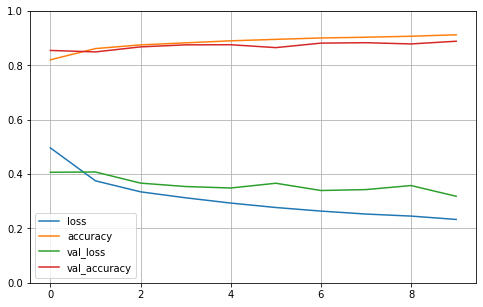

In [67]:
# Model a simple 3-hidden neural network 
model_3H = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_3H.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_3H.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_3H.evaluate(X_test, y_test)
print("Model - 3 Hidden layers - test loss:", test_loss * 100)
print("Model - 3 Hidden layers - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3834 - accuracy: 0.8742
Model - 6 Hidden layers - test loss: 38.3355587720871
Model - 6 Hidden layers - test accuracy: 87.41999864578247


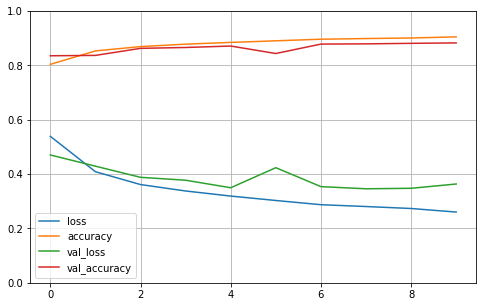

In [68]:
# Model a simple 6-hidden neural network 
model_6H = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_6H.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_6H.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_6H.evaluate(X_test, y_test)
print("Model - 6 Hidden layers - test loss:", test_loss * 100)
print("Model - 6 Hidden layers - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

313/313 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8695
Model - 10 Hidden layers - test loss: 37.97152042388916
Model - 10 Hidden layers - test accuracy: 86.94999814033508


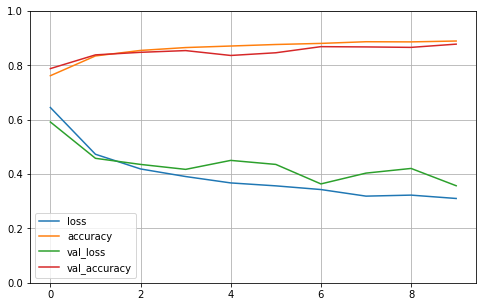

In [69]:
# Model a simple 10-hidden neural network 
model_10H = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_10H.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_10H.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_10H.evaluate(X_test, y_test)
print("Model - 10 Hidden layers - test loss:", test_loss * 100)
print("Model - 10 Hidden layers - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3414 - accuracy: 0.8823
Model - 3 HL 64 HU - test loss: 34.14093852043152
Model - 3 HL 64 HU - test accuracy: 88.23000192642212


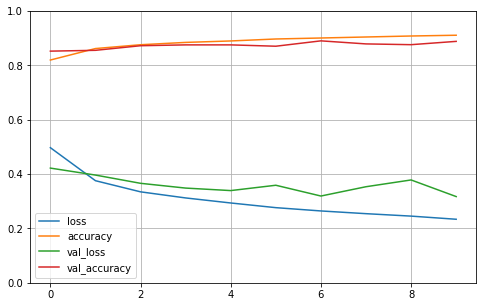

In [70]:
# Model a simple 3-hidden neural network , but different hidden units
model_3H_200 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_3H_200.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_3H_200.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_3H_200.evaluate(X_test, y_test)
print("Model - 3 HL 64 HU - test loss:", test_loss * 100)
print("Model - 3 HL 64 HU - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3318 - accuracy: 0.8868
Model - 3 HL 256 HU - test loss: 33.180034160614014
Model - 3 HL 256 HU - test accuracy: 88.67999911308289


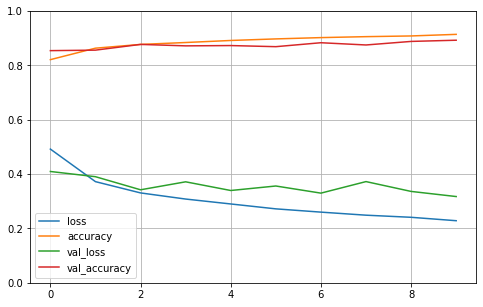

In [71]:
# Model a simple 3-hidden neural network , but different hidden units
model_3H_400 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(400, activation=tf.nn.relu),
    keras.layers.Dense(400, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_3H_400.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_3H_400.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_3H_400.evaluate(X_test, y_test)
print("Model - 3 HL 256 HU - test loss:", test_loss * 100)
print("Model - 3 HL 256 HU - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3584 - accuracy: 0.8814
Model - 3 HL 256 HU - test loss: 35.83984375
Model - 3 HL 256 HU - test accuracy: 88.13999891281128


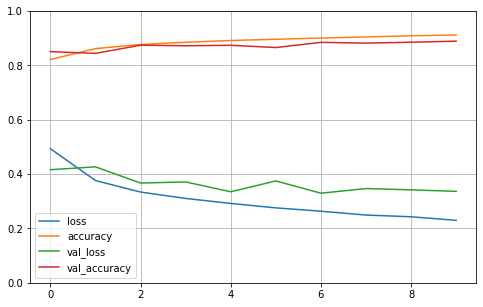

In [72]:
# Model a simple 3-hidden neural network , but different hidden units
model_3H_500 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(500, activation=tf.nn.relu),
    keras.layers.Dense(500, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_3H_500.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
results = model_3H_500.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
test_loss, test_acc = model_3H_500.evaluate(X_test, y_test)
print("Model - 3 HL 256 HU - test loss:", test_loss * 100)
print("Model - 3 HL 256 HU - test accuracy:", test_acc * 100)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

#### **Summary / Findings** <br>
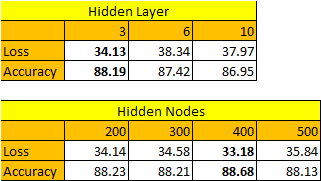

<br>Hidden Layer : As we increased hidden layer, loss values increases while the accuracy decreases.
<br>Hidden Nodes : We got min loss value for size 400, while accuracy increased with increase of hidden nodes. <br>We want the loss to be small, and the accuracy to be as large as possible but we cannot sacrifice loss at the cost of accuracy Hence for our model we select Hidden Layer = 3 and Hidden Nodes = 300 (as when we select 400, due to GPU limitation we get execution error even though the execution succeeds)



### Evaluating optimal learning rate 

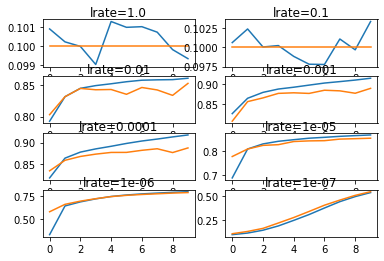

In [73]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, lrate):
  # Model a simple 3-hidden neural network 
  model_lr = keras.Sequential([
      keras.layers.Flatten(input_shape=(28,28)),
      keras.layers.Dense(400, activation=tf.nn.relu),
      keras.layers.Dense(400, activation=tf.nn.relu),
      keras.layers.Dense(100, activation=tf.nn.relu),
      keras.layers.Dense(10, activation=tf.nn.softmax)
  ])

  # compile model
  opt = Adam(learning_rate=lrate)
  model_lr.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model_lr.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, verbose=0)
  # plot learning curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('lrate='+str(lrate), pad=-50)

# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
 
# show learning curves
plt.show()

#### **Summary / Findings** <br/>
The plots show oscillations in behavior for the too-large learning rate of 1.0 and the inability of the model to learn anything with the too-small learning rates of 1E-6 and 1E-7.

We can see that the model was able to learn well with the learning rates 1E-1, 1E-2 and 1E-3, although successively slower as the learning rate was decreased. 

**With the chosen model configuration, the results suggest a moderate learning rate of 0.001 will results in good model performance on the train and test sets as it seems to be more smooth compared to 0.1 and 0.01**

### Evaluate Model with No Regularization

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_242 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_243 (Dense)            (None, 100)               30100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_244 (Dense)            (None, 10)                1010      
Total params: 356,910
Trainable params: 356,910
Non-trainable params: 0
_______________________________________________

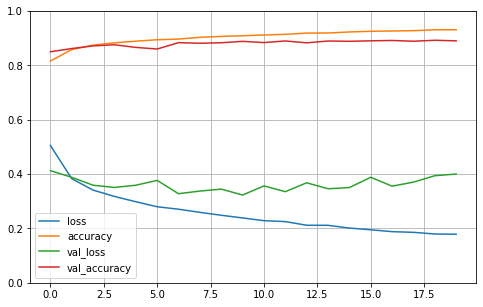

In [74]:
# Build the model
model_noreg = keras.Sequential()

# Input Layer
# The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). 
# Basically this layer as unstacks rows of pixels in the image and line them up. This layer has no parameters to learn; it only reformats the data.
model_noreg.add(keras.layers.Flatten(input_shape=(28, 28)))

# Adding 3 Hidden tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. We use different neurons with activation function = 'relu'
model_noreg.add(keras.layers.Dense(300, activation='relu'))
model_noreg.add(keras.layers.Dense(300, activation='relu'))
model_noreg.add(keras.layers.Dense(100, activation='relu'))
model_noreg.add(keras.layers.Dropout(0.1))

# Output Layer
# Given that the problem is a multi-class classification, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. 
# The last layer is a dense layer with a softmax activation function that classifies the 10 categories of the data and has 10 neurons.
model_noreg.add(keras.layers.Dense(10, activation='softmax'))

model_noreg.summary()

# Model Compile
# Loss function — calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. 
#                 we chose the sparse_categorical_crossentropy loss function. Cross-entropy is the default loss function to use for a multi-class classification problem, 
#                 and it's sparse because our targets are not one-hot encodings but are integers.

# Learning Rate parameter has been selected as 0.001 based on evaluation done later for various lr=[1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
model_noreg.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Evaluation
start_time = time.time()

results = model_noreg.fit(X_train, y_train,epochs= 20,validation_split = 0.2)

print("\nTraining time took %s seconds ---" % (time.time() - start_time))

# Model Evaluation
print("\nTraining Accuracy: ", np.mean(results.history["val_accuracy"]))

# Model Evaluation using test data
test_loss, test_acc = model_noreg.evaluate(X_test,  y_test, verbose=2)

# Plot loss and validation accuracy
plot_hist_loss_acc_v2(results)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.78      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.83      0.78      0.80      1000
       Dress       0.90      0.89      0.89      1000
        Coat       0.82      0.81      0.81      1000
      Sandal       0.99      0.94      0.97      1000
       Shirt       0.65      0.79      0.71      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



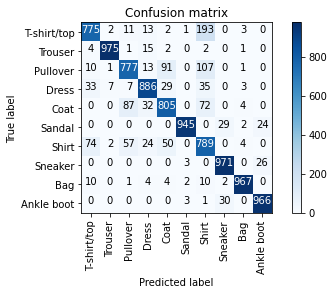

In [75]:
# Predict the values from the validation dataset
Y_pred = model_noreg.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)

# Computing Classification Report
print('Classification Report:')
print(classification_report(y_test, Y_pred_classes, target_names=class_names))

#### Regularisation / No Regularisation Summary

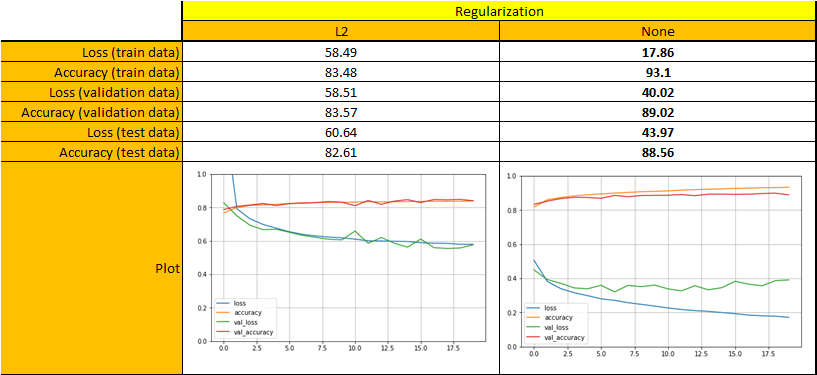
<br>

The overall accuracy , loss values are much better when not applying L2 Regularisation, the major benefit of applying L2 Regularisation is that we get consistent model as evident from the Plot between Training and Validation data, and also when we evaluate the model using Test Data the results remain very consistent, while this fluctuates more with No Regularisation

In [76]:
secs = time.time() - program_start_time
mins = secs / 60
print("Training time took %s seconds ---" % "{:.2f}".format(secs))
print("Training time took %s mins ---" % "{:.2f}".format(mins))

Training time took 699.94 seconds ---
Training time took 11.67 mins ---
